### 1) GET LIBRARY

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd

### 2) GENERATE DATA

In [74]:
np.random.seed(1234)

In [75]:
def generate_toy_data(n, lam, a, b):
    '''Generate random number from poisson distribution.
    Input:
    n = number of data points to generate
    lam = lambda of the poisson distribution
    a, b = any positive coefficient (since we want to simulate demand) 
    
    Output:
    x = independent variable
    y = demand for toy data that results from a*x + b, with x ~ poisson(lam)
    '''
    x = np.random.poisson(lam, n)
    x = x.reshape((-1,1))
    
    y = a*x + b
    y = y.reshape((-1,1))
    y = y.astype(int)
    
    return x, y

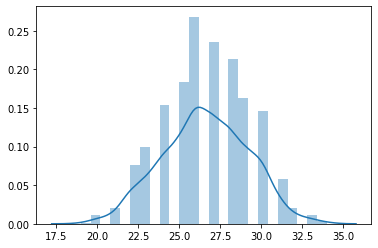

In [76]:
# generate toy data
x, y = generate_toy_data(1000, 100, 0.25, 2)

# visualize toy data
plt.figure()
sns.distplot(y)
plt.show()

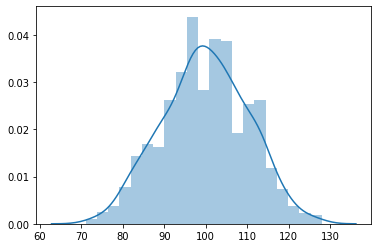

In [78]:
# visualize toy data x
plt.figure()
sns.distplot(x)
plt.show()

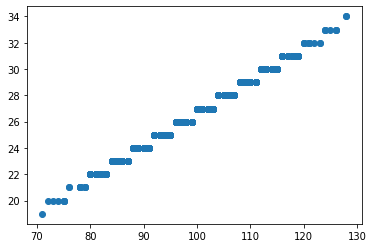

In [77]:
plt.figure()
plt.scatter(x, y)
plt.show()

### 3) IMPLEMENT SIMPLE PREDICTION

In [45]:
# split data to training and testing set
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)

In [46]:
df_train = pd.DataFrame({'train_x': train_x.flatten(), 'train_y': train_y.flatten()})
df_test = pd.DataFrame({'test_x': test_x.flatten(), 'test_y': test_y.flatten()})

#### a) RANDOM FOREST

In [47]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_x, train_y)

C:\Users\jkapila\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [48]:
test_y_rfpred = (rf.predict(test_x)).astype(int)
err_rf = abs(test_y_rfpred - test_y)
print('Mean Absolute Error:', round(np.mean(err_rf), 2), 'degrees.')

Mean Absolute Error: 3.05 degrees.


#### b) LINEAR REGRESSION

In [49]:
lr = LinearRegression()
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
test_y_lrpred = (rf.predict(test_x)).astype(int)
err_lr = abs(test_y_lrpred - test_y)
print('Mean Absolute Error:', round(np.mean(err_lr), 2), 'degrees.')

Mean Absolute Error: 3.05 degrees.


In [51]:
# check coefficient
print(lr.coef_)
print(lr.intercept_)

[[0.25079062]]
[1.54812364]


#### c) SUMMARIZE RESULT & CHECK GRAPH (RANDOM FOREST & LINREG)

In [52]:
df_summ = pd.DataFrame({'test_x': test_x.flatten(),
                        'test_y': test_y.flatten(), 
                        'test_y_rfpred': test_y_rfpred.flatten(), 
                        'test_y_lrpred': test_y_lrpred.flatten()})
df_summ['diff_rf_actual'] = df_summ['test_y_rfpred'] - df_summ['test_y']
df_summ['diff_lr_actual'] = df_summ['test_y_lrpred'] - df_summ['test_y']

# toy data is simple, hence prediction is rather powerful as we only have few missed prediction
# even so, in this kind of cases:
# --> we will lose potential profit if prediction < demand
# --> we will incur unnecessary cost if prediction > demand as we cannot sell the remaining goods at selling price 
df_summ[(df_summ['diff_rf_actual'] != 0) | (df_summ['diff_lr_actual'] != 0)] 

,test_x,test_y,test_y_rfpred,test_y_lrpred,diff_rf_actual,diff_lr_actual
34,120,32,31,31,-1,-1
80,80,22,21,21,-1,-1
83,120,32,31,31,-1,-1
84,116,31,30,30,-1,-1
86,72,20,19,19,-1,-1
104,80,22,21,21,-1,-1
167,116,31,30,30,-1,-1
182,116,31,30,30,-1,-1
193,80,22,21,21,-1,-1


<Figure size 432x288 with 0 Axes>

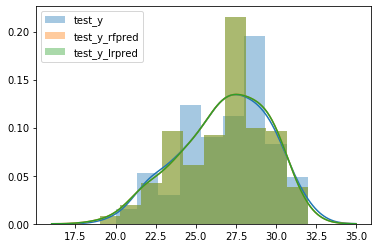

In [53]:
plt.figure()

components = [test_y, test_y_rfpred, test_y_lrpred]
labels=['test_y', 'test_y_rfpred', 'test_y_lrpred']

fig, axes = plt.subplots(1)
for component in components:
    sns.distplot(component)

axes.legend(labels=labels)    
plt.show()

### 4) STOCHASTIC PROGRAMMING
#### a) DISCRETIZING DEMAND: TO CAPTURE PROBABILITY OF EACH POSSIBLE SCENARIO

In [54]:
# capturing probability of each possible scenario can be done in many ways, 
# ranging from simple descriptive analytics to more complicated things like
# moment matching, monte carlo simulation, etc.
# we do the easiest here: do clustering to generate scenario (max 100 scenario for now)

from sklearn.cluster import KMeans

In [55]:
def cluster_1d(df, max_cluster=100):
    '''Cluster data into n different cluster where n is the minimum between unique scenario and max_cluster.
    Input:
    df = dataframe column containing scenario to cluster
    max_cluster = number of maximum cluster we want to have (default=100)
    
    Output:
    cluster_centers_df = mapping between cluster labels and its centers
    cluster_labels_df = mapping between df and its cluster labels   
    '''
    km = KMeans(n_clusters=min(len(df.unique()),max_cluster))
    km.fit(df.values.reshape(-1,1)) 
    
    # get information about center
    centers = np.array(km.cluster_centers_.reshape(1,-1)[0].tolist())
    cluster_centers_df = pd.DataFrame({'cluster_centers':centers,'labels':range(len(centers))})
#     cluster_centers_df.columns = ['cluster_centers']
#     cluster_centers_df['labels'] = range(cluster_centers_df.count())
    
    # get information about labels and add information about center
    cluster_labels_df = pd.DataFrame(np.array(km.labels_))
    cluster_labels_df.columns = ['labels']
    cluster_labels_df = pd.concat([df.reset_index(drop=True), cluster_labels_df], axis=1)
    cluster_labels_df = pd.merge(cluster_labels_df, cluster_centers_df, on='labels', how='left')
    
    return cluster_centers_df, cluster_labels_df

In [81]:
def cluster_summ(df):
    '''Summarize probability for each scenario by referring to result from cluster_1d.
    Input:
    df = dataframe column containing scenario to cluster
    
    Output:
    cluster_proportion_df = dataframe containing complete information about probability for each scenario
    demand = possible scenario to happen
    weight = probability of the possible scenario to happen
    scenarios = indexing for demand
    '''
    cluster_centers_df, cluster_labels_df = cluster_1d(df)
    print(cluster_centers_df.head())
    print(cluster_labels_df.head())

    count_label = cluster_labels_df[['labels']].count().values[0]
    cluster_proportion_df = cluster_labels_df[['cluster_centers', 'labels']].groupby('cluster_centers').count().reset_index(drop=False)
    cluster_proportion_df['count_labels'] = count_label
    cluster_proportion_df['proportion_labels'] = cluster_proportion_df['labels'] / cluster_proportion_df['count_labels']
    cluster_proportion_df['index'] = range(1,cluster_proportion_df.shape[0] + 1)
    cluster_proportion_df['cluster_centers'] = np.round(cluster_proportion_df['cluster_centers'], decimals=(3))
    
    demand = pd.Series(cluster_proportion_df['cluster_centers'].values, index=cluster_proportion_df['index'].values).to_dict()
    weight = pd.Series(cluster_proportion_df['proportion_labels'].values, index=cluster_proportion_df['index'].values).to_dict()
    scenarios = range(1,len(cluster_proportion_df.cluster_centers.values)+1)
    
    return cluster_proportion_df, demand, weight, scenarios

In [90]:
cluster_proportion_df, demand, weight, scenarios = cluster_summ(df=df_train['train_y'])

print('\nValues wee need to see      : ',demand)
print('\nOccurences of values        : ',weight)
print('\nNumber osf scenarios(Values): ',scenarios)

   cluster_centers  labels
0             27.0       0
1             24.0       1
2             29.0       2
3             30.0       3
4             26.0       4
   train_y  labels  cluster_centers
0       27       0             27.0
1       26       4             26.0
2       24       1             24.0
3       31       9             31.0
4       30       3             30.0

Values wee need to see      :  {1: 19.0, 2: 20.0, 3: 21.0, 4: 22.0, 5: 23.0, 6: 24.0, 7: 25.0, 8: 26.0, 9: 27.0, 10: 28.0, 11: 29.0, 12: 30.0, 13: 31.0, 14: 32.0, 15: 33.0, 16: 34.0}

Occurences of values        :  {1: 0.00125, 2: 0.00625, 3: 0.0125, 4: 0.04, 5: 0.065, 6: 0.09375, 7: 0.1175, 8: 0.17125, 9: 0.13875, 10: 0.1275, 11: 0.09, 12: 0.0825, 13: 0.0325, 14: 0.01, 15: 0.00875, 16: 0.0025}

Number osf scenarios(Values):  range(1, 17)


In [80]:
cluster_proportion_df.head()

,cluster_centers,labels,count_labels,proportion_labels,index
0,19.0,1,800,0.00125,1
1,20.0,5,800,0.00625,2
2,21.0,10,800,0.01250,3
3,22.0,32,800,0.04000,4
4,23.0,52,800,0.06500,5


In [87]:
cluster_proportion_df

,cluster_centers,labels,count_labels,proportion_labels,index
0,19.0,1,800,0.00125,1
1,20.0,5,800,0.00625,2
2,21.0,10,800,0.01250,3
3,22.0,32,800,0.04000,4
4,23.0,52,800,0.06500,5
5,24.0,75,800,0.09375,6
6,25.0,94,800,0.11750,7
7,26.0,137,800,0.17125,8
8,27.0,111,800,0.13875,9
9,28.0,102,800,0.12750,10


In [83]:
19.0/800

0.02375

In [86]:
sum([i[1] for i in weight.items()])

1.0000000000000002

#### b) USING PULP TO SOLVE STOCHASTIC PROGRAMMING

In [58]:
# !pip install pulp pygmo deap

In [59]:
from pulp import *

N = 100         # maximum item to purchase
cost_price = 20 # amount paid to the supplier
sell_price = 21 # amount paid by the customer
waste_price = 0 # amount paid if we sell the remaining goods (ie. when we have more stock as prediction > demand)

In [60]:
##########################################
# DEFINE VARIABLES
##########################################

# Defining our problem statement 
M = LpProblem("Newsvendor1", LpMaximize)

# Defining the variable which needs to be optimized
x = LpVariable('x', lowBound=0)

# Defining the scenarios / value demamds / clusterd y values
z = LpVariable.dicts('z', scenarios, 0)

print('Problem Statement: ',M)
print('X variable: ',x)
print('Z variable: ',z)

##########################################
# DEFINE MODELS: CONSTRAINTS
##########################################

for i in scenarios:
    print(demand[i])
    print(weight[i])
    M += x <= N # the maximum value our independent varaible can have for a scenario
    M += z[i] <= x # telling the scenario cannot have more casses than its occurence
    M += z[i] <= demand[i] # defining the upper limit of values a scenario can attain

print('Problem Statement with constraints: ', M)
print('X variable: ', x)
print('Z variable: ', z)
    
##########################################
# DEFINE MODELS: OBJECTIVE
##########################################

M += sum(weight[i] * (sell_price * z[i] + waste_price * (x - z[i])) for i in scenarios) - (cost_price * x) 

print('Problem Statement with constraints and solution points: ',M)
M.solve()


Problem Statement:  Newsvendor1:
MAXIMIZE
None
VARIABLES

X variable:  x
Z variable:  {1: z_1, 2: z_2, 3: z_3, 4: z_4, 5: z_5, 6: z_6, 7: z_7, 8: z_8, 9: z_9, 10: z_10, 11: z_11, 12: z_12, 13: z_13, 14: z_14, 15: z_15, 16: z_16}
19.0
0.00125
20.0
0.00625
21.0
0.0125
22.0
0.04
23.0
0.065
24.0
0.09375
25.0
0.1175
26.0
0.17125
27.0
0.13875
28.0
0.1275
29.0
0.09
30.0
0.0825
31.0
0.0325
32.0
0.01
33.0
0.00875
34.0
0.0025
Problem Statement with constraints:  Newsvendor1:
MAXIMIZE
None
SUBJECT TO
_C1: x <= 100

_C2: - x + z_1 <= 0

_C3: z_1 <= 19

_C4: x <= 100

_C5: - x + z_2 <= 0

_C6: z_2 <= 20

_C7: x <= 100

_C8: - x + z_3 <= 0

_C9: z_3 <= 21

_C10: x <= 100

_C11: - x + z_4 <= 0

_C12: z_4 <= 22

_C13: x <= 100

_C14: - x + z_5 <= 0

_C15: z_5 <= 23

_C16: x <= 100

_C17: - x + z_6 <= 0

_C18: z_6 <= 24

_C19: x <= 100

_C20: - x + z_7 <= 0

_C21: z_7 <= 25

_C22: x <= 100

_C23: - x + z_8 <= 0

_C24: z_8 <= 26

_C25: x <= 100

_C26: - x + z_9 <= 0

_C27: z_9 <= 27

_C28: x <= 100

_C2

1

In [61]:
##########################################
# PRINT RESULTS
##########################################

print("Status = %s" % LpStatus[M.status])

print("%s = %f" % (x.name, x.varValue))
for i in scenarios:
    print("%s = %f" % (z[i].name, z[i].varValue))
print("Objective = %f" % (M.objective.value()))

Status = Optimal
x = 22.000000
z_1 = 19.000000
z_2 = 20.000000
z_3 = 21.000000
z_4 = 22.000000
z_5 = 22.000000
z_6 = 22.000000
z_7 = 22.000000
z_8 = 22.000000
z_9 = 22.000000
z_10 = 22.000000
z_11 = 22.000000
z_12 = 22.000000
z_13 = 22.000000
z_14 = 22.000000
z_15 = 22.000000
z_16 = 22.000000
Objective = 21.396250


#### c) CHECK AS TABLE (MANUAL CALCULATION): TO SEE CLEARLY WHAT HAPPENS

In [62]:
def result_summ(cluster_proportion_df, demand, weight, sell_price, cost_price, waste_price):
    '''Summarize result by comparing possible scenario (example_df) with its possible execution (purchase_df).
    We want to look how much profit we can get given a pair of scenario and its execution, 
    weighted with the probability of each scenario to happen.
    Input:
    cluster_proportion_df = dataframe containing complete information about probability for each scenario
    demand = possible scenario to happen
    weight = probability of the possible scenario to happen
    cost_price = amount paid to the supplier
    sell_price = amount paid by the customer
    waste_price = amount paid if we sell the remaining goods

    Output:
    example_df = dataframe after cross join between possible scenario and possible execution
    example_df_summ = summary of example_df to obtain total expected profit per possible execution
    '''
    
    # get the basic df: purchase_df for the demand and example_df for the possible scenario execution
    purchase_df = pd.DataFrame({'key': 0, 'item_to_purchase': demand})
    example_df = pd.DataFrame({'key': 0, 'item_to_sell': cluster_proportion_df['cluster_centers'], 
                               'probability': cluster_proportion_df['proportion_labels']})
    example_df = example_df.merge(purchase_df, on='key', how='outer')
    example_df = example_df.drop('key', axis=1).sort_values(['item_to_purchase', 'item_to_sell'])
    
    example_df['total_revenue'] = example_df[['item_to_sell', 'item_to_purchase']].min(axis=1) * sell_price
    example_df['total_cost'] = example_df['item_to_purchase'] * cost_price
    example_df['total_profit'] = (example_df['total_revenue'] - example_df['total_cost'])
    
    example_df['total_weighted_profit'] = example_df['probability'] * example_df['total_profit']
    example_df['total_cumsum_profit'] = example_df.groupby('item_to_purchase')['total_weighted_profit'].cumsum()

    example_df_summ = example_df.groupby('item_to_purchase', as_index=False)['total_weighted_profit'].sum()
    
    return example_df, example_df_summ

In [63]:
example_df, example_df_summ = result_summ(cluster_proportion_df=cluster_proportion_df, demand=demand, weight=weight, 
                                          sell_price=sell_price, cost_price=cost_price, waste_price=waste_price)
example_df

,item_to_sell,probability,item_to_purchase,total_revenue,total_cost,total_profit,total_weighted_profit,total_cumsum_profit
0,19.0,0.00125,19.0,399.0,380.0,19.0,0.02375,0.02375
16,20.0,0.00625,19.0,399.0,380.0,19.0,0.11875,0.14250
32,21.0,0.01250,19.0,399.0,380.0,19.0,0.23750,0.38000
48,22.0,0.04000,19.0,399.0,380.0,19.0,0.76000,1.14000
64,23.0,0.06500,19.0,399.0,380.0,19.0,1.23500,2.37500
...,...,...,...,...,...,...,...,...
191,30.0,0.08250,34.0,630.0,680.0,-50.0,-4.12500,-122.07250
207,31.0,0.03250,34.0,651.0,680.0,-29.0,-0.94250,-123.01500
223,32.0,0.01000,34.0,672.0,680.0,-8.0,-0.08000,-123.09500
239,33.0,0.00875,34.0,693.0,680.0,13.0,0.11375,-122.98125


#### d) VISUAL CHECK

In [64]:
# limit the table, we don't want to be overwhelmed
temp = example_df[(example_df['item_to_purchase'] >= 20) & (example_df['item_to_purchase'] <= 25)]
temp.loc[:,'item_to_purchase'] = temp['item_to_purchase'].astype('str')

C:\Users\jkapila\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


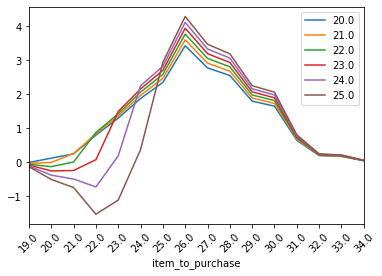

In [65]:
# check the weighted profit per possible scenario: 
# we can see how higher execution causes greater loss during weak demand and hence,
# higher execution number has difficulty in bouncing the profit up 

fig, ax = plt.subplots()

for i in temp['item_to_purchase'].unique():
    temp[temp['item_to_purchase'] == i].plot.line(x='item_to_purchase', y='total_weighted_profit', ax=ax, label=str(i))
plt.xticks(range(0,np.unique(temp['item_to_sell']).shape[0]),np.unique(temp['item_to_sell']),rotation=45)
plt.show()

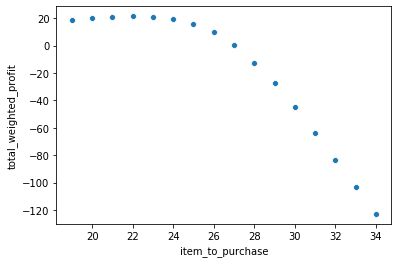

In [66]:
# check the total expected profit, which comes from all possible profit 
# and weighted by the probability of the scenario to happen
plt.figure()
sns.scatterplot(x='item_to_purchase', y='total_weighted_profit', data=example_df_summ)
plt.show()

### 5) PREDICTION + STOCHASTIC PROGRAMMING
#### a) BOOTSTRAPPING

In [67]:
size_bstrap = 50
iter = 100
idx_check = 172
test_y_bstrap = []
coef_bstrap = []
intercept_bstrap = []

for i in range(iter):
    
    # sampling with replacement
    idx = np.random.choice(np.arange(0,train_x.shape[0]), size_bstrap, replace=True)
    train_x_temp = train_x[idx]
    train_y_temp = train_y[idx]
    
    # do linear regression
    lr_bstrap = LinearRegression()
    lr_bstrap.fit(train_x_temp, train_y_temp)
    
    # get coefficient and intercept
    coef_bstrap.append(lr_bstrap.coef_)
    intercept_bstrap.append(lr_bstrap.intercept_)
    
    # get result, only for intended index idx_check
    # test_y_bstrap.append((lr_bstrap.predict(test_x)[idx_check][0]).astype(int))
    result_temp = np.rint(lr_bstrap.intercept_ + lr_bstrap.coef_ * test_x[idx_check])[0,0]
    test_y_bstrap.append(result_temp)
    

In [68]:
result_bstrap = pd.DataFrame({'test_y_bstrap': test_y_bstrap})
result_bstrap['test_x_bstrap'] = test_x[idx_check][0]
result_bstrap

,test_y_bstrap,test_x_bstrap
0,29.0,110
1,29.0,110
2,29.0,110
3,29.0,110
4,29.0,110
...,...,...
95,29.0,110
96,29.0,110
97,29.0,110
98,29.0,110


In [69]:
result_bstrap_summ = result_bstrap.groupby('test_y_bstrap').count().reset_index(drop=False)
result_bstrap_summ

,test_y_bstrap,test_x_bstrap
0,29.0,100


#### b) DISCRETIZING DEMAND

In [37]:
cluster_proportion_df_bstrap, demand_bstrap, weight_bstrap, scenarios_bstrap = cluster_summ(df=result_bstrap['test_y_bstrap'])

print(demand_bstrap)
print(weight_bstrap)
print(scenarios_bstrap)

{1: 26.0}
{1: 1.0}
range(1, 2)


#### c) USING PULP TO SOLVE STOCHASTIC PROGRAMMING

In [91]:
##########################################
# DEFINE VARIABLES
##########################################

M_bstrap = LpProblem("Newsvendor2", LpMaximize)

x_bstrap = LpVariable('x_bstrap', lowBound=0)
z_bstrap = LpVariable.dicts('z_bstrap', scenarios_bstrap, 0)


##########################################
# DEFINE MODELS: CONSTRAINTS
##########################################

for i in scenarios_bstrap:
    print(demand_bstrap[i])
    print(weight_bstrap[i])
    M_bstrap += x_bstrap <= N
    M_bstrap += z_bstrap[i] <= x_bstrap
    M_bstrap += z_bstrap[i] <= demand_bstrap[i]

    
##########################################
# DEFINE MODELS: OBJECTIVE
##########################################

M_bstrap += sum(weight_bstrap[i] * (sell_price * z_bstrap[i] + waste_price * (x_bstrap - z_bstrap[i])) for i in scenarios_bstrap) - (cost_price * x_bstrap) 
M_bstrap.solve()


##########################################
# PRINT RESULTS
##########################################

print("Status = %s" % LpStatus[M_bstrap.status])

print("%s = %f" % (x_bstrap.name, x_bstrap.varValue))
for i in scenarios_bstrap:
    print("%s = %f" % (z_bstrap[i].name, z_bstrap[i].varValue))
print("Objective = %f" % (M_bstrap.objective.value()))



33.0
0.13
34.0
0.87
Status = Optimal
x_bstrap = 33.000000
z_bstrap_1 = 33.000000
z_bstrap_2 = 33.000000
Objective = 33.000000


#### d) CHECK AS TABLE (MANUAL CALCULATION): TO SEE CLEARLY WHAT HAPPENS

In [93]:
example_df_bstrap, example_df_summ_bstrap = result_summ(cluster_proportion_df=cluster_proportion_df_bstrap, 
                                                        demand=demand_bstrap, weight=weight_bstrap, 
                                                        sell_price=sell_price, cost_price=cost_price, 
                                                        waste_price=waste_price)
example_df_bstrap.head(n=5)

,item_to_sell,probability,item_to_purchase,total_revenue,total_cost,total_profit,total_weighted_profit,total_cumsum_profit
0,33.0,0.13,33.0,693.0,660.0,33.0,4.29,4.29
2,34.0,0.87,33.0,693.0,660.0,33.0,28.71,33.00
1,33.0,0.13,34.0,693.0,680.0,13.0,1.69,1.69
3,34.0,0.87,34.0,714.0,680.0,34.0,29.58,31.27


In [92]:
# optimal decision will only change if we increase sales_price (eg. sales_price = 23)
example_df_bstrap, example_df_summ_bstrap = result_summ(cluster_proportion_df=cluster_proportion_df_bstrap, 
                                                        demand=demand_bstrap, weight=weight_bstrap, 
                                                        sell_price=23, cost_price=cost_price, 
                                                        waste_price=waste_price)
example_df_bstrap.head(n=5)

,item_to_sell,probability,item_to_purchase,total_revenue,total_cost,total_profit,total_weighted_profit,total_cumsum_profit
0,33.0,0.13,33.0,759.0,660.0,99.0,12.87,12.87
2,34.0,0.87,33.0,759.0,660.0,99.0,86.13,99.00
1,33.0,0.13,34.0,759.0,680.0,79.0,10.27,10.27
3,34.0,0.87,34.0,782.0,680.0,102.0,88.74,99.01


#### d) VISUAL CHECK

In [83]:
example_df_bstrap.loc[:,'item_to_purchase'] = example_df_bstrap['item_to_purchase'].astype('str')

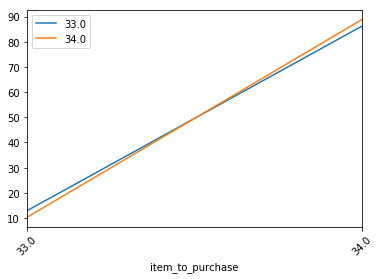

In [84]:
# check the weighted profit per possible scenario: 
# we can see how higher execution causes greater loss during weak demand and hence,
# higher execution number has difficulty in bouncing the profit up 

fig, ax = plt.subplots()

for i in example_df_bstrap['item_to_purchase'].unique():
    example_df_bstrap[example_df_bstrap['item_to_purchase'] == i].plot.line(x='item_to_purchase', y='total_weighted_profit', ax=ax, label=str(i))
plt.xticks(range(0,np.unique(example_df_bstrap['item_to_sell']).shape[0]),np.unique(example_df_bstrap['item_to_sell']),rotation=45)
plt.show()

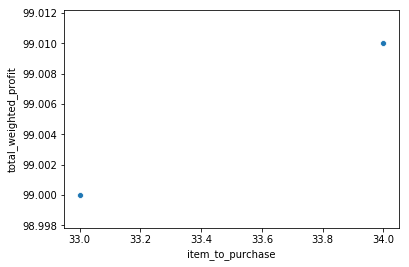

In [85]:
# check the total expected profit, which comes from all possible profit 
# and weighted by the probability of the scenario to happen
plt.figure()
sns.scatterplot(x='item_to_purchase', y='total_weighted_profit', data=example_df_summ_bstrap)
plt.show()